In [21]:
from aspire.basis.basis_utils import lgwt
import numpy as np
import matplotlib.pyplot as plt

# adaptive quad subroutines
# the following three can be passed
# as the method parameter to the main adaptive_quad() function

def eval_composite_trap(M,a,b,f):
    """
    put code from prelab with same returns as gauss_quad
    you can return None for the weights
    """
    x = np.linspace(a, b, M)
    h = (b - a) / (M - 1)

    w = np.ones(M) * h
    w[0] /= 2
    w[-1] /= 2

    # Approximate the integral
    I_hat = np.sum(w * f(x))
    return I_hat, x, w

def eval_composite_simpsons(M,a,b,f):
    """
    put code from prelab with same returns as gauss_quad
    you can return None for the weights
    """
    x = np.linspace(a, b, M)
    approx = 0
    for i in range(1, M-1, 1):
        a = x[i-1]
        b = x[i]
        approx += (b-a)/6 * ( f(a) +4*f((a+b)/2) + f(b) )
    return approx, x, None

def eval_gauss_quad(M,a,b,f):
    """
    Non-adaptive numerical integrator for int_a^b f(x)w(x)dx
    Input:
      M - number of quadrature nodes
      a,b - interval [a,b]
      f - function to integrate

    Output:
      I_hat - approx integral
      x - quadrature nodes
      w - quadrature weights

    Currently uses Gauss-Legendre rule
    """
    x,w = lgwt(M,a,b)
    I_hat = np.sum(f(x)*w)
    return I_hat,x,w

def adaptive_quad(a,b,f,tol,M,method):
    """
    Adaptive numerical integrator for int_a^b f(x)dx

    Input:
    a,b - interval [a,b]
    f - function to integrate
    tol - absolute accuracy goal
    M - number of quadrature nodes per bisected interval
    method - function handle for integrating on subinterval
           - eg) eval_gauss_quad, eval_composite_simpsons etc.

    Output: I - the approximate integral
            X - final adapted grid nodes
            nsplit - number of interval splits
    """
    # 1/2^50 ~ 1e-15
    maxit = 50
    left_p = np.zeros((maxit,))
    right_p = np.zeros((maxit,))
    s = np.zeros((maxit,1))
    left_p[0] = a; right_p[0] = b;
    # initial approx and grid
    s[0],x,_ = method(M,a,b,f);
    # save grid
    X = []
    X.append(x)
    j = 1;
    I = 0;
    nsplit = 1;
    while j < maxit:
        # get midpoint to split interval into left and right
        c = 0.5*(left_p[j-1]+right_p[j-1]);
        # compute integral on left and right spilt intervals
        s1,x,_ = method(M,left_p[j-1],c,f); X.append(x)
        s2,x,_ = method(M,c,right_p[j-1],f); X.append(x)
        if np.max(np.abs(s1+s2-s[j-1])) > tol:
            left_p[j] = left_p[j-1]
            right_p[j] = 0.5*(left_p[j-1]+right_p[j-1])
            s[j] = s1
            left_p[j-1] = 0.5*(left_p[j-1]+right_p[j-1])
            s[j-1] = s2
            j = j+1
            nsplit = nsplit+1
        else:
            I = I+s1+s2
            j = j-1
            if j == 0:
                j = maxit
    return I,np.unique(X),nsplit



<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matth\AppData\Local\Temp\ipykernel_22436\3245711513.py:18: SyntaxWarning: invalid escape sequence '\s'
  f = lambda x: np.sin(1./x); I_true = 1.1455808341; labl = '$\sin(1/x)$'


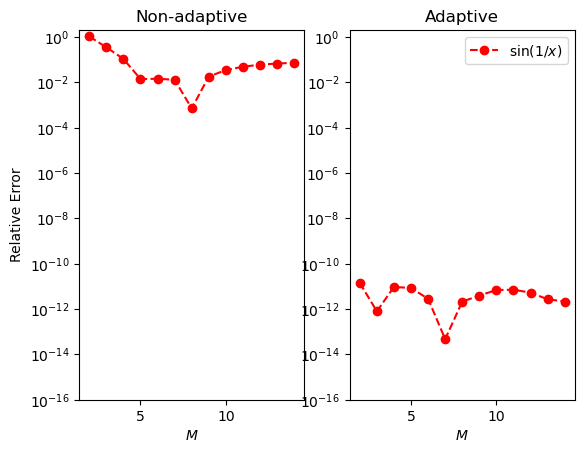

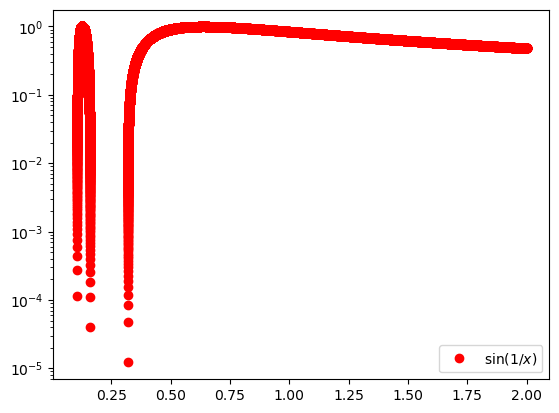

In [25]:
# This script tests the convergence of adaptive quad
# and compares to a non adaptive routine

# specify the quadrature method
# (eval_gauss_quad, eval_composite_trap, eval_composite_simpsons)
method = eval_composite_trap
# interval of integration [a,b]
# a = 0.; b = 1.
# function to integrate and true values
# TRYME: uncomment and comment to try different funcs
#        make sure to adjust I_true values if using different interval!
# f = lambda x: np.log(x)**2; I_true = 2; labl = '$\\log^2(x)$'
# f = lambda x: 1./(np.power(x,(1./5.))); I_true = 5./4.; labl = '$\\frac{1}{x^{1/5}}$'
# f = lambda x: np.exp(np.cos(x)); I_true = 2.3415748417130531; labl = '$\\exp(\\cos(x))$'
#f = lambda x: x**20; I_true = 1./21.; labl = '$x^{20}$'
# below is for a=0.1, b = 2
a = 0.1; b = 2
f = lambda x: np.sin(1./x); I_true = 1.1455808341; labl = '$\\sin(1/x)$'

# absolute tolerance for adaptive quad
tol = 1e-14
# machine eps in numpy
eps = np.finfo(float).eps

# number of nodes and weights, per subinterval
Ms = np.arange(2,15); nM = len(Ms)
# storage for error
err_old = np.zeros((nM,))
err_new = np.zeros((nM,))


# loop over quadrature orders
# compute integral with non adaptive and adaptive
# compute errors for both
for iM in range(nM):
    M = Ms[iM];
    # non adaptive routine
    # Note: the _,_ are dummy vars/Python convention
    # to store uneeded returns from the routine
    I_old,_,_ = method(M,a,b,f)
    # adaptive routine
    I_new,X,nsplit = adaptive_quad(a,b,f,tol,M,method)
    err_old[iM] = np.abs(I_old-I_true)/I_true
    err_new[iM] = np.abs(I_new-I_true)/I_true
    # clean the error for nice plots
    if err_old[iM] < eps:
        err_old[iM] = eps
    if err_new[iM] < eps:
        err_new[iM] = eps
    # save grids for M = 2
    if M == 2:
        mesh = X

# plot the old and new error for each f and M
fig,ax = plt.subplots(1,2)
ax[0].semilogy(Ms,err_old,'ro--')
ax[0].set_ylim([1e-16,2]);
ax[0].set_xlabel('$M$')
ax[0].set_title('Non-adaptive')
ax[0].set_ylabel('Relative Error');
ax[1].semilogy(Ms,err_new,'ro--',label=labl)
ax[1].set_ylim([1e-16,2]);
ax[1].set_xlabel('$M$')
ax[1].set_title('Adaptive')
ax[1].legend()
plt.show()

# plot the adaptive mesh for M=2
fig,ax = plt.subplots(1,1)
ax.semilogy(mesh,f(mesh),'ro',label=labl)
ax.legend()
plt.show()
